<a href="https://colab.research.google.com/github/ShoSato-047/STAT380/blob/main/STAT380_4_5_(2025)_contrasts_with_multiple_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

When fitting multiple logistic regression models, especially with interaction terms, we often want to look at relationships of $logit(p)$ with an $X_1$ at specific values of $X_2$.  Just as in ordinary linear regression, we can use `emmeans`  to produce these odds ratio summarizing relationships of $logit(p)$ with $X_1$ given $X_2$.

# Case study: texting while driving

The data for this problem again come from the 2019 U.S. Youth Risk Behavior Surveillance System [(YRBSS)](https://www.cdc.gov/healthyyouth/data/yrbs/index.htm).

Question 11 on the YRBSS asks: *During the past 30 days, on how many days did you text or e-mail while driving a car or other vehicle?*  For this problem our response variable $Y$ is 0 if the teen answered "0 days" and 1 if they answered 1 or more days.


In [1]:
library(dplyr)
yrbss19 <- read.csv('https://www.dropbox.com/s/xvpibcmck10yuvk/yrbss2019.csv?dl=1') %>%
  mutate(Seatbelt = ifelse(Seatbelt=='Yes',1,0)) %>%
      mutate(Textdrive = ifelse(Textdrive=='Yes',1,0)) %>%
    filter(Sex!="" & Grade!='Ungraded or other grade'& Grade!='') %>%
      mutate(Grade = factor(Grade, levels = c('9th grade','10th grade','11th grade','12th grade')))
head(yrbss19)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,Age,Sex,Grade,Ride_with_drinking,Seatbelt,Textdrive,Bullying
,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<chr>
1,16 years old,Male,10th grade,0 times,1,0,No
2,15 years old,Male,10th grade,1 time,1,0,Yes
3,15 years old,Female,10th grade,0 times,1,0,No
4,15 years old,Male,10th grade,0 times,1,0,No
5,16 years old,Male,10th grade,0 times,1,0,No
6,15 years old,Female,10th grade,0 times,1,0,Yes


***Research questions:***  

1. Is texting while driving related to sex?

2.  Is texting while driving related to grade level?

3. Is the relationship of texting with sex different for different grade levels?

In [2]:
#Code for widening plots:
library(repr)
options(repr.plot.width=8, repr.plot.height=6)

# Exploratory analysis

As always, before model-fitting it's very helpful to visualize the relationships of interest.

## Relationship with sex

First, let's visualize the relationship of texting with sex:

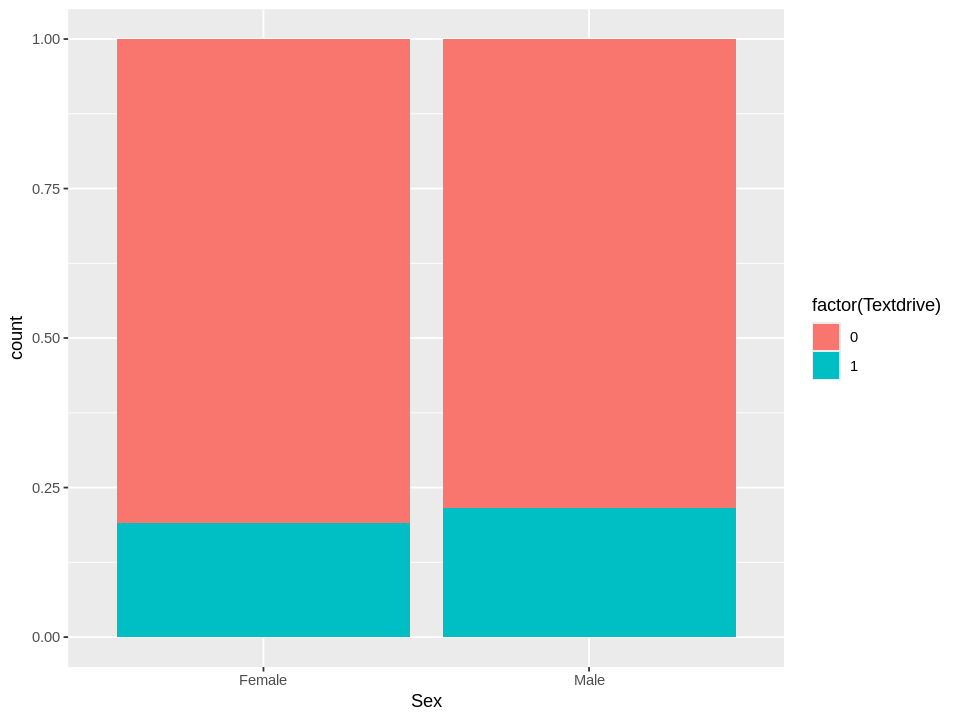

In [3]:
library(ggplot2)
ggplot(data = yrbss19) +
  geom_bar(aes(x = Sex, fill = factor(Textdrive)), position='fill')

In [4]:
yrbss19 %>%
  group_by(Sex,Textdrive) %>%
    summarize(cnt= n()) %>%
      mutate(pct = cnt/sum(cnt)) %>%
        mutate(odds = pct / (1-pct))

`summarise()` has grouped output by 'Sex'. You can override using the `.groups`
argument.


Sex,Textdrive,cnt,pct,odds
<chr>,<dbl>,<int>,<dbl>,<dbl>
Female,0,5547,0.8095447,4.2505747
Female,1,1305,0.1904553,0.2352623
Male,0,5174,0.7845337,3.6410978
Male,1,1421,0.2154663,0.2746424


It looks like there's only a slight difference in the rates.  22% of males say they text while driving, compared to 19% of females.

This corresponds to an odds of texting that is 0.27 for males, and 0.24 for females.

## Relationship with grade

What about the relationship of texting while driving with grade level?

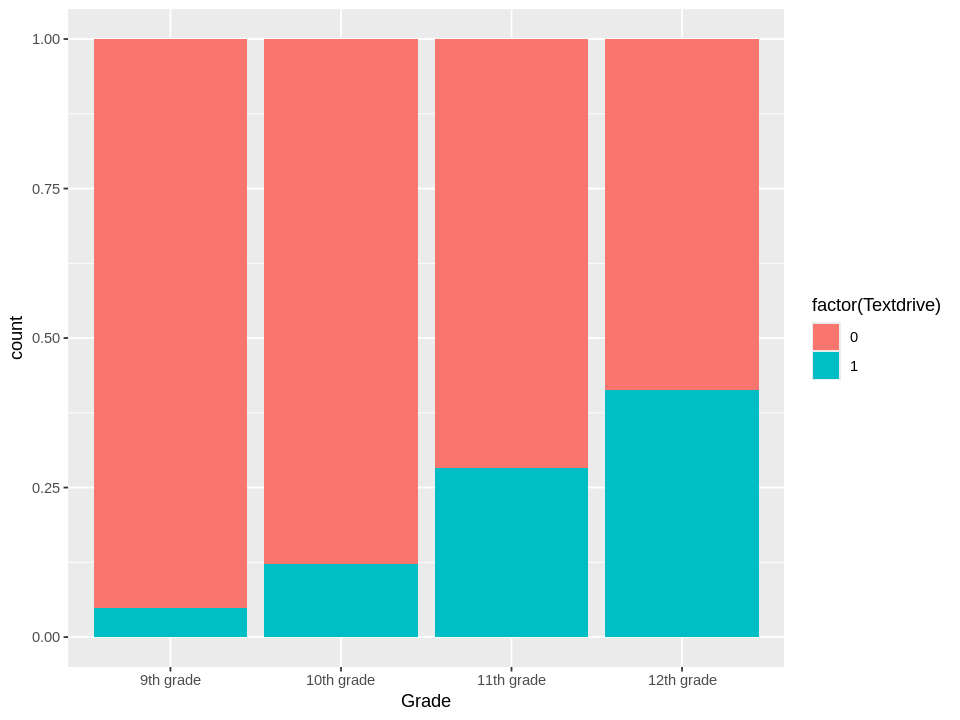

In [5]:
library(ggplot2)
ggplot(data = yrbss19) +
  geom_bar(aes(x = Grade, fill = factor(Textdrive)), position='fill')

In [6]:
yrbss19 %>%
  group_by(Grade,Textdrive) %>%
    summarize(cnt= n()) %>%
      mutate(pct = cnt/sum(cnt)) %>%
        mutate(odds = pct / (1-pct)) %>%
          filter(Textdrive==1)

`summarise()` has grouped output by 'Grade'. You can override using the
`.groups` argument.


Grade,Textdrive,cnt,pct,odds
<fct>,<dbl>,<int>,<dbl>,<dbl>
9th grade,1,176,0.04864566,0.05113306
10th grade,1,449,0.12168022,0.13853749
11th grade,1,933,0.28204353,0.39284211
12th grade,1,1168,0.41257506,0.70234516


There is a clear relationship of grade level with texting: higher grade levels are more likely to respond that they text while driving.

## Relationship with sex, BY grade

Does the slight relationship with sex depend on grade level?  To visualize this we can re-create our text/sex bar graph, faceted by grade level:

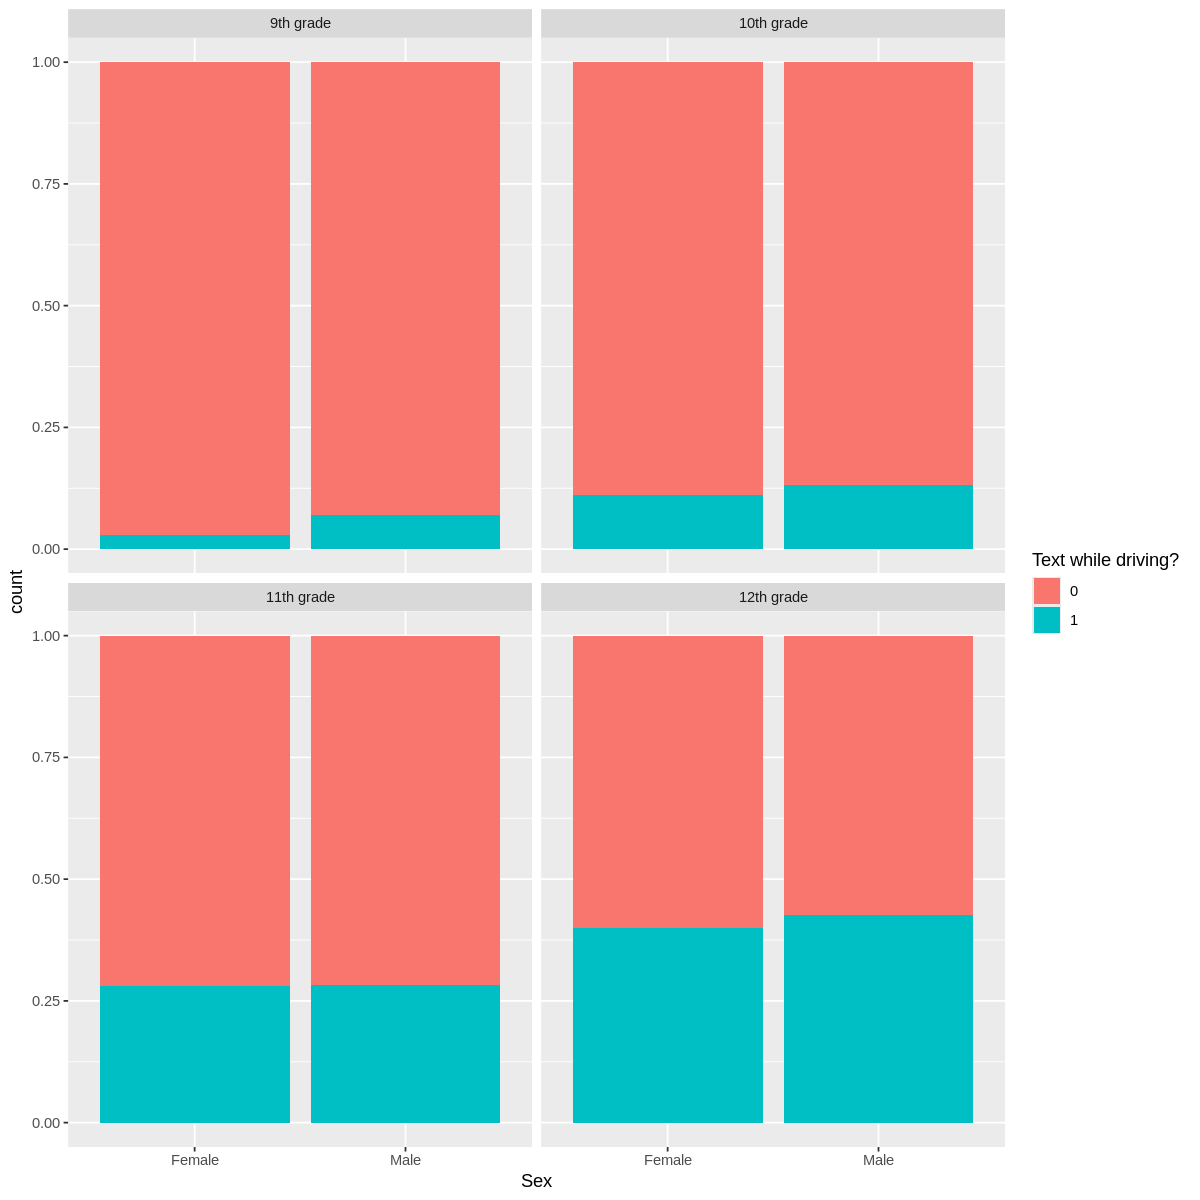

In [7]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(data = yrbss19) +
  geom_bar(aes(x = Sex, fill = factor(Textdrive)), position='fill')  +
    facet_wrap(~Grade) +
      scale_fill_discrete(name='Text while driving?')

It looks like the sex relationship is strongest for 9th graders, and weakest for 11th graders.  

# Modeling

## Relationship with sex

Let's first fit a simple logistic model of the form:

$$ logit(p_i) = \beta_0 + \beta_1 X_i,$$

where:

$X_i = \begin{cases} 1 & Males \\
0 & Females \\
\end{cases}
$

In [8]:
sexfit <- glm(Textdrive~Sex, data = yrbss19, family=binomial)
summary(sexfit)


Call:
glm(formula = Textdrive ~ Sex, family = binomial, data = yrbss19)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.44705    0.03077 -47.034  < 2e-16 ***
SexMale      0.15477    0.04294   3.605 0.000313 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13559  on 13446  degrees of freedom
Residual deviance: 13546  on 13445  degrees of freedom
AIC: 13550

Number of Fisher Scoring iterations: 4


In [9]:
exp(coefficients(sexfit))

(Intercept)     SexMale 
  0.2352623   1.1673882

In [10]:
exp(confint(sexfit))

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),0.2214107,0.2497926
SexMale,1.0731966,1.2699323


*  $\exp(\hat\beta_0) = 0.24$, the odds of texting while driving are 0.24 for females (24 females text for every 100 that do not).
* $\exp(\hat\beta_1) = 1.17$, the odds of texting while driving for males are 1.17 times higher than for females.
* Is there evidence that texting is related to sex?

**YES: p-value for the odds ratio = 0.0003 < 0.05, 95% CI for the odds ratio (1.07, 1.27) does not overlap 1.**

## Adjusting for grade level


Next, we can adjust for grade level.  Since there are 4 grades, we'll have 3 grade indicator variables:

$$ logit(p) = \beta_0 + \beta_1 X + \beta_2 U_{10} + \beta_3 U_{11} + \beta_4 U_{12}$$

where:

$U_k = \begin{cases} 1 & \mbox{Student is in grade }k\\
0& otherwise \\
\end{cases}
$

In [11]:
sex.grade.additive.fit <- glm(Textdrive~Sex + Grade, data = yrbss19, family=binomial)
summary(sex.grade.additive.fit)


Call:
glm(formula = Textdrive ~ Sex + Grade, family = binomial, data = yrbss19)

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.04976    0.08072 -37.783  < 2e-16 ***
SexMale          0.15541    0.04572   3.399 0.000676 ***
Grade10th grade  0.99349    0.09226  10.769  < 2e-16 ***
Grade11th grade  2.03653    0.08642  23.566  < 2e-16 ***
Grade12th grade  2.61954    0.08622  30.384  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13559  on 13446  degrees of freedom
Residual deviance: 11902  on 13442  degrees of freedom
AIC: 11912

Number of Fisher Scoring iterations: 5


In [12]:
exp(coefficients(sex.grade.additive.fit ))

(Intercept)         SexMale Grade10th grade Grade11th grade Grade12th grade 
     0.04737051      1.16813505      2.70064346      7.66395596     13.72939285

* Interpret $\exp(\hat\beta_1)$.  How does its interpretation change from the simple model fit on sex alone?  Does this interpretation seem valid, given what we know about how the sex relationship depends on grade level?

**The odds of texting while driving for males are 1.17 times higher than for females, comparing students in the same grade level.**

## Modeling an interaction


We know from our exploratory analysis that the texting/sex relationship is strongest for 9th graders, and might not even be there at all for the higher grade levels.  Modeling an interaction between sex and grade allows relationship of the log-odds of texting with sex to vary by grade level.  The full interaction model is:


$$ logit(p) = \beta_0 + \beta_1 X + \beta_2 U_{10} + \beta_3 U_{11} + \beta_4 U_{12} + \beta_5 X\cdot U_{10} + \beta_6 X\cdot U_{11} + \beta_7 X \cdot U_{12} $$

In [13]:
sex.grade.interaction.fit <- glm(Textdrive~Sex + Grade + Sex *  Grade, data = yrbss19, family=binomial)
summary(sex.grade.interaction.fit)


Call:
glm(formula = Textdrive ~ Sex + Grade + Sex * Grade, family = binomial, 
    data = yrbss19)

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -3.4772     0.1345 -25.856  < 2e-16 ***
SexMale                   0.8804     0.1647   5.347 8.96e-08 ***
Grade10th grade           1.4038     0.1534   9.153  < 2e-16 ***
Grade11th grade           2.5358     0.1452  17.468  < 2e-16 ***
Grade12th grade           3.0717     0.1448  21.207  < 2e-16 ***
SexMale:Grade10th grade  -0.6927     0.1932  -3.586 0.000336 ***
SexMale:Grade11th grade  -0.8664     0.1819  -4.763 1.91e-06 ***
SexMale:Grade12th grade  -0.7748     0.1815  -4.268 1.97e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13559  on 13446  degrees of freedom
Residual deviance: 11877  on 13439  degrees of freedom
AIC: 11893

Number of Fisher Scoring iterations: 6


All the interaction terms individually appear significant.  We can test whether modeling an interaciton term is an improvement on the no-interaction model with the drop-in-deviance/likelihood ratio test of the hypotheses:

$$H_0: \mbox{Additive sex + grade model sufficient; } \beta_5 = \beta_6 = \beta_7 = 0$$
$$H_a: \mbox{Interaction between sex and grade is an improvement; at least one of } \beta_5, \beta_6, \beta_7 \ne 0$$

In [14]:
anova(sex.grade.additive.fit,sex.grade.interaction.fit, test = 'Chisq')

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,13442,11901.69,NA,NA,NA
2,13439,11877.21,3,24.47681,1.986148e-05


Since the p-value < .0001, there is statistically significant evidence to support including an interaction between grade and sex when modeling the log-odds of texting while driving.  

# Grade-specific sex contrasts


With our interaction model, we can investigate the texting/sex relationship separately for each grade level.  How can we do this?

Reconsider the interaction model coefficients:

In [15]:
summary(sex.grade.interaction.fit)$coefficients

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-3.4771833,0.1344834,-25.855848,2.091247e-147
SexMale,0.8804246,0.1646673,5.346687,8.957889e-08
Grade10th grade,1.4037987,0.1533762,9.152653,5.555242e-20
Grade11th grade,2.5358328,0.1451732,17.467637,2.527471e-68
Grade12th grade,3.0717182,0.1448424,21.207317,8.174427e-100
SexMale:Grade10th grade,-0.6927313,0.1931657,-3.586203,3.355274e-04
SexMale:Grade11th grade,-0.8664148,0.1818979,-4.763192,1.905543e-06
SexMale:Grade12th grade,-0.7748138,0.1815203,-4.268470,1.968179e-05


* Suppose we want to test whether the log-odds of texting while driving differ significantly by sex, ***among 9th graders***.  Which coefficient(s) represent this contrast?

$$\mbox{9th grade males: }logit(p|male, 9th) = \hat\beta_0 + \hatΒ_1$$
$$\mbox{9th grade females: }logit(p|female, 9th) = \hat\beta_0$$
$$\mbox{9th grade male-female contrast: } logit(p|male, 9th) - logit(p|female, 9th) = \hat\beta_1  $$

* Can we test this contrast directly from the `summary()` output?

In [27]:
# SexMale
# males texting is 2.41 times higher than females
exp(0.88)

[1] 2.4109


* Suppose we want to test whether the log-odds of texting while driving differ significantly by sex, ***among 10th graders***.  Which coefficient(s) represent this contrast?

$$\mbox{10th grade males: }logit(p|male, 10th) = \beta_0 + \beta_1 + \beta_2 + \beta_5$$
$$\mbox{10th grade females: }logit(p|female, 10th) = $$
$$\mbox{10th grade male-female contrast: } logit(p|male, 10th) - logit(p|female, 10th)  $$

* Can we test this contrast directly from the `summary()` output?

In [29]:
# Find odds ratio for 10th grade males/ 10th grade females:
exp(0.880424 + - 0.692731)

# is this statistically significant odds ratio?

[1] 1.206463

Determining whether there is a texting/sex relationship for the upper grade levels requires testing linear combinations of coefficients, which are best facilitated with `emmeans()`.

In [17]:
install.packages('emmeans')
library(emmeans)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘estimability’, ‘numDeriv’, ‘mvtnorm’


Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



The structure of `emmeans`:

1. Produce the fitted values you want to contrast:

```modeled_values <- emmeans(model, specs, type, at)```
 * `model`: the GLM
 * `specs`: specifies for which variable you want the fitted values
 * `type`: do you want the fittd values on the linear (logit) or response ($p$) scale?
 * `at`: specific values of covariates for which you want fitted values computed

2. Contrast the fitted values; this produces contrast estimates and p-values:

```contrast_them <- contrast(modeled_values, method = )```

Most useful methods: "pairwise", "revpairwise", "consec"

3.  Produce confidence intervals for contrast:

```confint(contrast_them)```


First step for us, set up the `emmeans` object.  To prepare for the contrasts we want, we are interested in the odds of texting for males and females, ***grouped by*** grade level:

In [33]:
(fitted_values_by_sex_grade_prob <- emmeans(sex.grade.interaction.fit, specs = ~Sex|Grade))

Grade = 9th grade:
 Sex    emmean     SE  df asymp.LCL asymp.UCL
 Female -3.477 0.1340 Inf    -3.741    -3.214
 Male   -2.597 0.0950 Inf    -2.783    -2.411

Grade = 10th grade:
 Sex    emmean     SE  df asymp.LCL asymp.UCL
 Female -2.073 0.0737 Inf    -2.218    -1.929
 Male   -1.886 0.0690 Inf    -2.021    -1.750

Grade = 11th grade:
 Sex    emmean     SE  df asymp.LCL asymp.UCL
 Female -0.941 0.0547 Inf    -1.049    -0.834
 Male   -0.927 0.0546 Inf    -1.034    -0.820

Grade = 12th grade:
 Sex    emmean     SE  df asymp.LCL asymp.UCL
 Female -0.405 0.0538 Inf    -0.511    -0.300
 Male   -0.300 0.0542 Inf    -0.406    -0.194

Results are given on the logit (not the response) scale. 
Confidence level used: 0.95 

In [36]:
# -3.477 = intercept
# -2.597 = B0 + B1
# type = 'response' -- proportion scale

(fitted_values_by_sex_grade_logit <- emmeans(sex.grade.interaction.fit, specs = ~Sex|Grade, at = list(Grade='10th grade'), type = 'response'))

Grade = 10th grade:
 Sex     prob      SE  df asymp.LCL asymp.UCL
 Female 0.112 0.00732 Inf    0.0982     0.127
 Male   0.132 0.00789 Inf    0.1170     0.148

Confidence level used: 0.95 
Intervals are back-transformed from the logit scale 

Remember that the default linear combinations are on the ***logit (log-odds)*** scale!  To get these on the odds scale, we specify `type = 'response'`:

In [19]:
(fitted_values_by_sex_grade_logit <- emmeans(sex.grade.interaction.fit, specs = ~Sex|Grade, type = 'response'))

Grade = 9th grade:
 Sex      prob      SE  df asymp.LCL asymp.UCL
 Female 0.0300 0.00391 Inf    0.0232    0.0387
 Male   0.0693 0.00613 Inf    0.0582    0.0824

Grade = 10th grade:
 Sex      prob      SE  df asymp.LCL asymp.UCL
 Female 0.1117 0.00732 Inf    0.0982    0.1269
 Male   0.1317 0.00789 Inf    0.1170    0.1480

Grade = 11th grade:
 Sex      prob      SE  df asymp.LCL asymp.UCL
 Female 0.2806 0.01100 Inf    0.2595    0.3028
 Male   0.2835 0.01110 Inf    0.2622    0.3057

Grade = 12th grade:
 Sex      prob      SE  df asymp.LCL asymp.UCL
 Female 0.4000 0.01290 Inf    0.3750    0.4255
 Male   0.4256 0.01330 Inf    0.3998    0.4518

Confidence level used: 0.95 
Intervals are back-transformed from the logit scale 

Now when specifying `method='pairwise'` in our `contrast()` command, the contrasts will take place by grade level, which is what we want:

In [35]:
contrast(fitted_values_by_sex_grade_prob, method = 'revpairwise')

Grade = 9th grade:
 contrast      estimate     SE  df z.ratio p.value
 Male - Female    0.880 0.1650 Inf   5.347  <.0001

Grade = 10th grade:
 contrast      estimate     SE  df z.ratio p.value
 Male - Female    0.188 0.1010 Inf   1.859  0.0631

Grade = 11th grade:
 contrast      estimate     SE  df z.ratio p.value
 Male - Female    0.014 0.0773 Inf   0.181  0.8561

Grade = 12th grade:
 contrast      estimate     SE  df z.ratio p.value
 Male - Female    0.106 0.0764 Inf   1.383  0.1668

Results are given on the log odds ratio (not the response) scale. 

In [21]:
# We don't need this code ?
confint(contrast(fitted_values_by_sex_grade_logit, method = 'pairwise'))

,contrast,Grade,odds.ratio,SE,df,asymp.LCL,asymp.UCL
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Female / Male,9th grade,0.4146068,0.06827220,Inf,0.3002419,0.5725343
2,Female / Male,10th grade,0.8288689,0.08370198,Inf,0.6800309,1.0102830
3,Female / Male,11th grade,0.9860878,0.07620057,Inf,0.8474975,1.1473416
4,Female / Male,12th grade,0.8997748,0.06872696,Inf,0.7746705,1.0450826


By default the odds ratios are odds of texting for females/males, if desired we can obtain the odds ratios on the males/females scale with `method='revpairwise')

In [22]:
contrast(fitted_values_by_sex_grade_logit, method = 'revpairwise')

Grade = 9th grade:
 contrast      odds.ratio     SE  df null z.ratio p.value
 Male / Female       2.41 0.3970 Inf    1   5.347  <.0001

Grade = 10th grade:
 contrast      odds.ratio     SE  df null z.ratio p.value
 Male / Female       1.21 0.1220 Inf    1   1.859  0.0631

Grade = 11th grade:
 contrast      odds.ratio     SE  df null z.ratio p.value
 Male / Female       1.01 0.0784 Inf    1   0.181  0.8561

Grade = 12th grade:
 contrast      odds.ratio     SE  df null z.ratio p.value
 Male / Female       1.11 0.0849 Inf    1   1.383  0.1668

Tests are performed on the log odds ratio scale 

In [38]:
# CI overlaps 1?
confint(contrast(fitted_values_by_sex_grade_prob, method = 'revpairwise'))

,contrast,Grade,estimate,SE,df,asymp.LCL,asymp.UCL
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Male - Female,9th grade,0.88042463,0.16466733,Inf,0.55768259,1.2031667
2,Male - Female,10th grade,0.18769330,0.10098337,Inf,-0.01023048,0.3856171
3,Male - Female,11th grade,0.01400987,0.07727564,Inf,-0.13744760,0.1654673
4,Male - Female,12th grade,0.10561080,0.07638241,Inf,-0.04409597,0.2553176


Interpretation of the 9th grade sex relationship:

* ***The odds of 9th grade males texting while driving are 2.4 times higher than for 9th grade females, a significantly higher odds (p-value < .0001, 95% CI for odds ratio: 1.7, 3.3 lies entirely above 1).***
* If we interpreted Female/Male: ***The odds of 9th grade females texting while driving are 41% as high as the odds for 9th grade males, a significantly lower odds (p-value < .0001, 95% CI for odds ratio: 0.3, 0.6 lies entirely below 1).***

Interpretation of the 10 grade sex relationship:

* ***The odds of 10th grade males texting while driving are 1.2 times higher than for 10th grade females, however this is not statistically significant (p-value = 0.06, 95% CI for odds ratio: 0.99, 1.47 includes 1).***


Similarly, the texting/sex relationships are not significant for 11th and 12th graders -- it appears the only significant relationship is for the 9th graders.

# Sex-specific grade contrasts

Your turn!  We saw early on that there was a strong relationship of texting with grade level. ***Does this relationship depend on sex, and if so, how?***


## Explore

Re-create the grade/texting stacked bar graph, but now facet by sex.  What do you think?

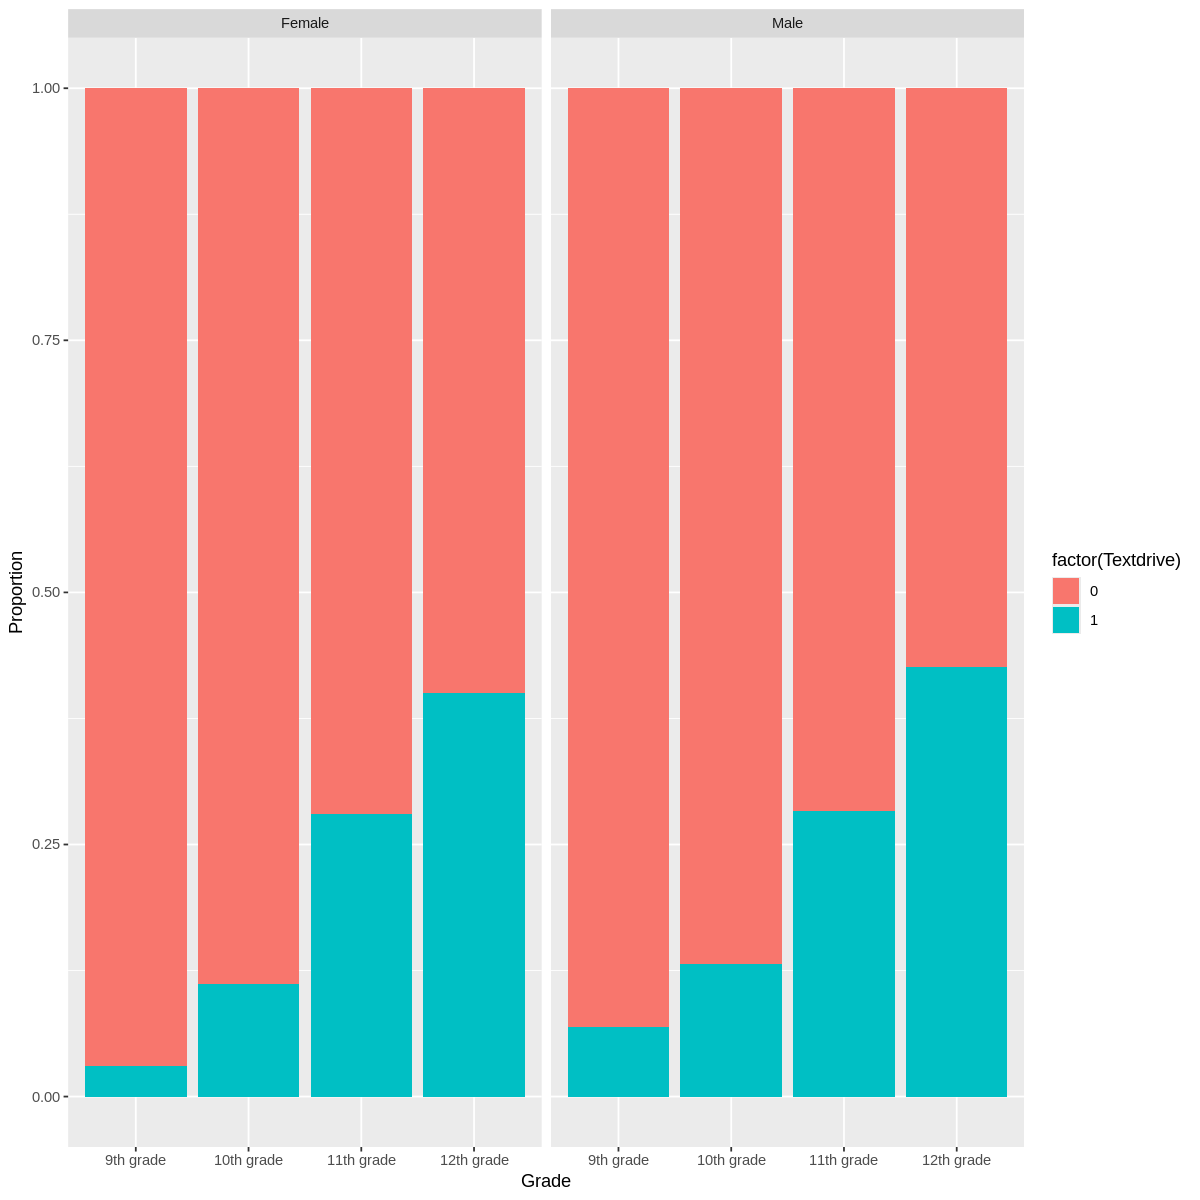

In [44]:
ggplot(data = yrbss19) +
  geom_bar(aes(x = Grade, fill = factor(Textdrive)), position='fill') +
  #scale_fill_discrete(name = '') +
  ylab('Proportion') +
  facet_wrap(~ Sex)

## Contrast

Use the full sex $\times$ grade interaction model, set up an `emmeans()` object that will allow you to compare consecutive grade levels to each other, ***separately by sex***.  Then contrast ***consecutive*** grade levels (9th to 10th, 10th to 11th, 11th to 12th) for males and females (hint: `method='consec'` when you contrast the fitted odds).  

* Is the 9th-to-10th contrast stronger for males or females? **Females. Odds ratio: 4 vs. 2.**
* Is the 10th-to-11th contrast stronger for males or females? **Females. 3.1 vs. 2.6**
* Is the 11th-to-12th contrast stronger for males or females? **Males. 1.7 vs 1.87**


In [47]:
emmeans(sex.grade.interaction.fit, specs = ~Grade|Sex, type='response') %>%
  contrast(method = 'consec')

Sex = Female:
 contrast                odds.ratio    SE  df null z.ratio p.value
 10th grade / 9th grade        4.07 0.624 Inf    1   9.153  <.0001
 11th grade / 10th grade       3.10 0.285 Inf    1  12.331  <.0001
 12th grade / 11th grade       1.71 0.131 Inf    1   6.987  <.0001

Sex = Male:
 contrast                odds.ratio    SE  df null z.ratio p.value
 10th grade / 9th grade        2.04 0.239 Inf    1   6.055  <.0001
 11th grade / 10th grade       2.61 0.229 Inf    1  10.892  <.0001
 12th grade / 11th grade       1.87 0.144 Inf    1   8.153  <.0001

P value adjustment: mvt method for 3 tests 
Tests are performed on the log odds ratio scale 